In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

sns.set(style="whitegrid")

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

data = pd.read_csv('meta_ml_energy_dataset_random_balanced.csv')
data.head()

,experiment_id,dataset_name,seed,data_fraction,n_samples,n_features,model_family,params,train_time_s,roc_auc,...,lr_max_iter,rf_n_estimators,rf_max_depth,mlp_hidden_total,mlp_hidden_layers,mlp_max_iter,complexity_score,baseline_auc,delta_auc,EAUG
0,1,titanic,438878,0.886878,633,5,log_reg,"{'C': 12.468786659075638, 'max_iter': 593, 'so...",0.040070,0.768205,...,593.0,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.012078,12980.894278
1,2,titanic,94177,0.980498,700,5,log_reg,"{'C': 6.158459876169436, 'max_iter': 321, 'sol...",0.012158,0.763686,...,321.0,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.007559,33431.549203
2,3,titanic,786064,0.302491,215,5,log_reg,"{'C': 11.080485964481502, 'max_iter': 631, 'so...",0.003001,0.753394,...,631.0,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.000000,0.000000
3,4,titanic,370798,0.941412,672,5,log_reg,"{'C': 0.6332041485861786, 'max_iter': 500, 'so...",0.014521,0.706364,...,500.0,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.000000,0.000000
4,5,titanic,822761,0.554731,396,5,log_reg,"{'C': 3.7623611419432557, 'max_iter': 441, 'so...",0.017715,0.763378,...,441.0,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.007251,34643.108008


C:\Users\frane\AppData\Local\Temp\ipykernel_5468\425510893.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset["EAUG_log"] = np.log1p(subset["EAUG"])


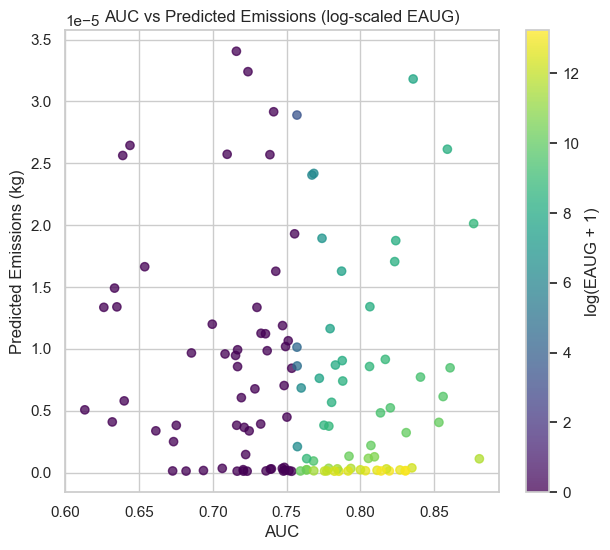

In [10]:
subset = data[(data['dataset_name'] == 'titanic')]

subset["EAUG_log"] = np.log1p(subset["EAUG"])

cmap = plt.cm.viridis
plt.figure(figsize=(7,6))
sc = plt.scatter(
    subset["roc_auc"],
    subset["emissions_kg"],
    c=subset["EAUG_log"],
    cmap=cmap,
    alpha=0.75
)
plt.colorbar(sc, label="log(EAUG + 1)")
plt.xlabel("AUC")
plt.ylabel("Predicted Emissions (kg)")
plt.title("AUC vs Predicted Emissions (log-scaled EAUG)")
plt.show()

In [12]:
# Best titanic models based on EAUG
best_models = subset.sort_values(by="EAUG", ascending=False).head(5)
best_models[["model_family", "roc_auc", "emissions_kg", "EAUG"]]
best_models

,experiment_id,dataset_name,seed,data_fraction,n_samples,n_features,model_family,params,train_time_s,roc_auc,...,rf_n_estimators,rf_max_depth,mlp_hidden_total,mlp_hidden_layers,mlp_max_iter,complexity_score,baseline_auc,delta_auc,EAUG,EAUG_log
10,11,titanic,967509,0.460660,328,5,log_reg,"{'C': 9.529028451003093, 'max_iter': 420, 'sol...",0.000000,0.830484,...,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.074357,557012.878911,13.230345
27,28,titanic,814020,0.333578,238,5,log_reg,"{'C': 0.42222840409817153, 'max_iter': 451, 's...",0.000000,0.819643,...,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.063516,500506.175989,13.123377
32,33,titanic,87649,0.294405,210,5,log_reg,"{'C': 0.2800595858297671, 'max_iter': 776, 'so...",0.000000,0.830588,...,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.074461,483940.264730,13.089719
39,40,titanic,432093,0.701847,501,5,log_reg,"{'C': 7.54834642976399, 'max_iter': 598, 'solv...",0.003151,0.814024,...,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.057897,469086.707974,13.058545
30,31,titanic,696320,0.556925,397,5,log_reg,"{'C': 0.040667587601763026, 'max_iter': 498, '...",0.006934,0.826823,...,NaN,NaN,NaN,NaN,NaN,5.0,0.756127,0.070696,345373.650440,12.752385


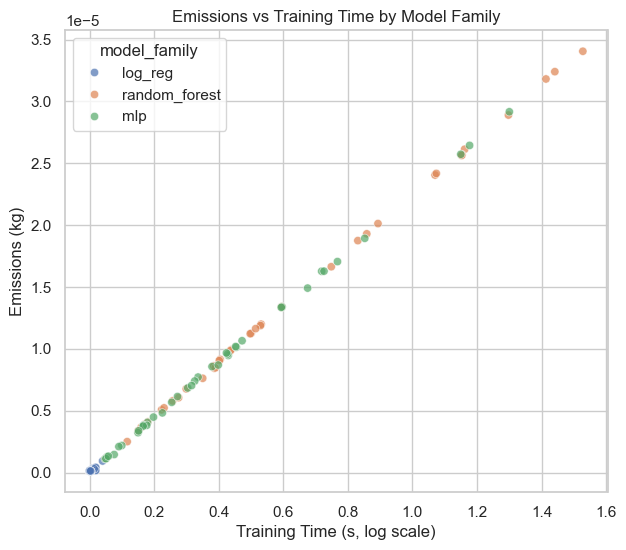

In [14]:
# Plot emission vs train_time_s
plt.figure(figsize=(7,6))
sns.scatterplot(data=subset, x='train_time_s', y='emissions_kg', hue='model_family', alpha=0.7)
plt.xlabel("Training Time (s, log scale)")
plt.ylabel("Emissions (kg)")
plt.title("Emissions vs Training Time by Model Family")
plt.show()

In [3]:
df = data[['n_samples', 'n_features', 'model_family', 'complexity_score', 'emissions_kg']]
df.head()

,n_samples,n_features,model_family,complexity_score,emissions_kg
0,633,5,log_reg,5.0,9.304569e-07
1,700,5,log_reg,5.0,2.261145e-07
2,215,5,log_reg,5.0,1.017997e-07
3,672,5,log_reg,5.0,3.332797e-07
4,396,5,log_reg,5.0,2.093201e-07


In [4]:
df['complexity_score'].describe()

count      479.000000
mean      5332.941545
std      10066.415244
min          2.000000
25%          5.500000
50%        980.000000
75%       5263.500000
max      70206.000000
Name: complexity_score, dtype: float64

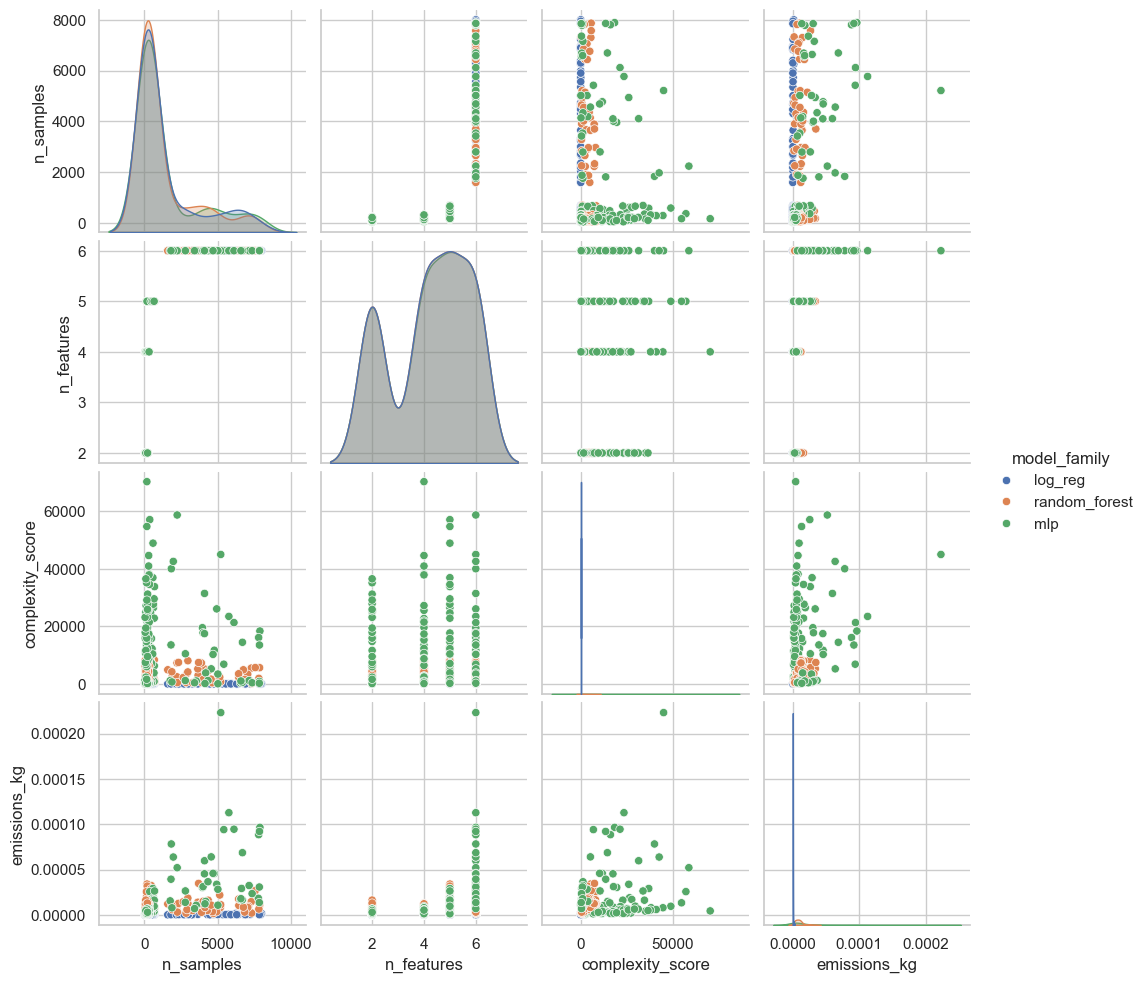

In [5]:
# Plots relations between n_samples, n_features, complexity_score, and emissions_kg
sns.pairplot(df, hue='model_family', vars=['n_samples', 'n_features', 'complexity_score', 'emissions_kg'])
plt.show()

In [6]:
X = df[['n_samples', 'n_features', 'model_family', 'complexity_score']]
y = df['emissions_kg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_features = ['model_family']
numerical_features = ['n_samples', 'n_features', 'complexity_score']

numerical_preprocessor = StandardScaler()
categorical_preprocessor = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[('numerical', numerical_preprocessor, numerical_features),
                  ('categorical', categorical_preprocessor, categorical_features)])

model1 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])

model2 = Pipeline(steps=[('preprocessor', preprocessor),
                         ('regressor', LinearRegression())])

model1.fit(X_train, y_train)
y_pred1 = model1.predict(X_test)
model2.fit(X_train, y_train)
y_pred2 = model2.predict(X_test)

In [7]:
print("Random Forest Regressor Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred1))
print("R^2 Score:", r2_score(y_test, y_pred1))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred1))
print("\nLinear Regression Performance:")
print("Mean Squared Error:", mean_squared_error(y_test, y_pred2))
print("R^2 Score:", r2_score(y_test, y_pred2))
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred2))

Random Forest Regressor Performance:
Mean Squared Error: 1.1595829097892139e-10
R^2 Score: 0.6264117576883212
Mean Absolute Error: 5.0923671168551165e-06

Linear Regression Performance:
Mean Squared Error: 2.065695550396837e-10
R^2 Score: 0.334485215926396
Mean Absolute Error: 9.039372900977472e-06


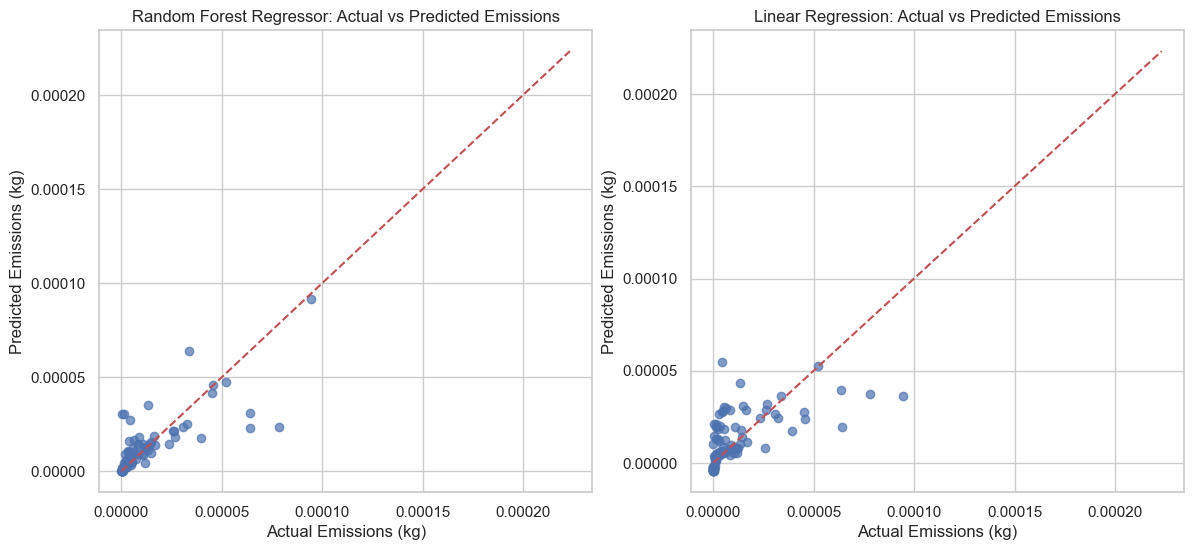

In [8]:
# Visualize real vs predicted emissions for both models
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred1, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Emissions (kg)')
plt.ylabel('Predicted Emissions (kg)')
plt.title('Random Forest Regressor: Actual vs Predicted Emissions')
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred2, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel('Actual Emissions (kg)')
plt.ylabel('Predicted Emissions (kg)')
plt.title('Linear Regression: Actual vs Predicted Emissions')
plt.show()